# K-means Clustering of Movie Ratings

Your task is to extract a meaningful vectorial representation of users given the interactions that they had with movies. You will then use these representations to segment the users in different groups. Finally you will describe these groups and visually illustrate them in slides that you will present in a 5-10 min presentation.

The data we'll be using comes from the wonderful [MovieLens](https://movielens.org/) [user rating dataset](https://grouplens.org/datasets/movielens/). We'll be looking at individual movie ratings in the notebook.


# 1 - Data Fetching


## Dataset overview
The dataset has two files. We'll import them both into pandas dataframes:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
import helper
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl


%matplotlib inline

# Import the Movies dataset & ratings datasets
ratings = pd.read_csv('./data/u.data', sep="\t", header=None)
movies = pd.read_csv('./data/u.item', sep="|", encoding='latin-1', header=None)
ratings.columns = ['userId', 'movieId', 'rating', 'timestamp'] 
movies.columns = ['movieId', 'title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 
            'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
            'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
ratings.head()


print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100000  ratings of  1682  movies.


# 2 - Pre-Processing

## Movie-level Clustering
How users rated individual movies? 
Dataset in the form of userId vs user rating for each movie. For example, let's look at a subset of the dataset:

In [2]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, 'user x movies' '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (943, 1664) user x movies

Subset example:


title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)"
userId,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN
6,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN


The dominance of NaN values presents the first issue. Most users have not rated and watched most movies. Datasets like this are called "sparse" because only a small number of cells have values. 

Let's sort by the most rated movies, and the users who have rated the most number of movies. That will present a more 'dense' region when we peak at the top of the dataset.

If we're to choose the most-rated movies vs users with the most ratings, it would look like this:

In [ ]:
#In the real model we will take the 1000 most rated movies
n_movies = 30
n_users = 18
most_rated_movies_users_selection = helper.sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title,Star Wars (1977),Contact (1997),Fargo (1996),Return of the Jedi (1983),Liar Liar (1997),"English Patient, The (1996)",Scream (1996),Toy Story (1995),Air Force One (1997),Independence Day (ID4) (1996),...,Titanic (1997),Mission: Impossible (1996),"Fugitive, The (1993)",Indiana Jones and the Last Crusade (1989),Willy Wonka and the Chocolate Factory (1971),"Princess Bride, The (1987)",Forrest Gump (1994),"Saint, The (1997)",Monty Python and the Holy Grail (1974),"Full Monty, The (1997)"
449,5.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,...,5.0,4.0,4.0,3.0,5.0,5.0,4.0,4.0,5.0,5.0
275,5.0,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,...,5.0,3.0,4.0,4.0,5.0,5.0,4.0,3.0,5.0,4.0
415,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,...,5.0,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0
177,5.0,4.0,4.0,5.0,2.0,3.0,5.0,4.0,5.0,5.0,...,5.0,3.0,4.0,5.0,NaN,5.0,5.0,4.0,4.0,4.0
536,4.0,4.0,4.0,2.0,1.0,3.0,2.0,2.0,1.0,1.0,...,4.0,2.0,3.0,3.0,2.0,4.0,2.0,NaN,4.0,3.0


That's more like it. Let's also establish a good way for visualizing these ratings so we can attempt to visually recognize the ratings (and later, clusters) when we look at bigger subsets.

Let's use colors instead of the number ratings:

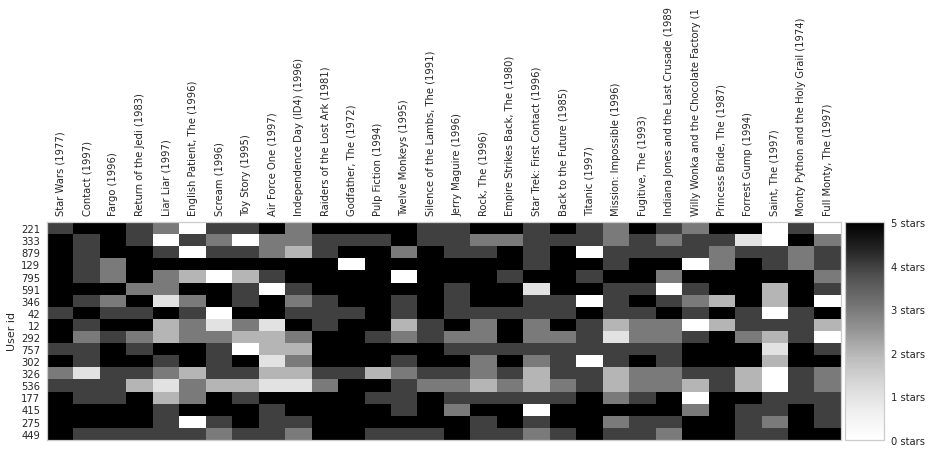

In [ ]:
helper.draw_movies_heatmap(most_rated_movies_users_selection)

In [ ]:
#df_random_values = pd.DataFrame(np.random.randint(0,5, size = (18,30)), columns=df.columns.to_list())

,Star Wars (1977),Contact (1997),Fargo (1996),Return of the Jedi (1983),Liar Liar (1997),"English Patient, The (1996)",Scream (1996),Toy Story (1995),Air Force One (1997),Independence Day (ID4) (1996),...,Titanic (1997),Mission: Impossible (1996),"Fugitive, The (1993)",Indiana Jones and the Last Crusade (1989),Willy Wonka and the Chocolate Factory (1971),"Princess Bride, The (1987)",Forrest Gump (1994),"Saint, The (1997)",Monty Python and the Holy Grail (1974),"Full Monty, The (1997)"
0,4,1,0,1,1,2,2,2,1,3,...,0,0,0,3,0,1,4,2,0,3
1,0,1,0,2,1,0,2,4,4,4,...,2,4,1,1,3,1,4,2,1,1
2,1,0,3,0,4,4,2,3,3,0,...,2,0,4,4,0,2,0,2,0,4
3,2,1,0,4,1,0,1,3,3,1,...,2,3,0,4,1,4,2,1,4,3
4,1,3,2,0,1,1,4,0,1,4,...,4,3,1,4,1,0,3,1,1,2
5,0,4,1,3,4,4,2,3,2,0,...,3,1,3,1,0,4,2,1,2,3
6,2,0,4,1,4,1,4,0,1,1,...,0,3,3,4,1,4,4,0,1,4
7,0,4,4,3,1,0,2,4,0,0,...,0,0,3,4,4,3,1,2,2,3
8,4,1,3,4,3,1,4,1,4,2,...,2,3,2,3,4,1,1,4,2,1
9,2,3,4,2,4,4,4,3,4,3,...,4,1,3,3,2,0,2,0,0,4


Each column is a movie. Each row is a user. The color of the cell is how the user rated that movie based on the scale on the right of the graph.

Cells are white? 
- This means the respective user did not rate that movie. 
- This makes it less straightforward to cluster users directly by their movie ratings as k-means generally does not like missing values.

For performance reasons, we'll only use ratings for 1000 movies (out of the 9000+ available in the dataset).

In [ ]:
df = most_rated_movies_users_selection.head()
df.columns.to_list()

['Star Wars (1977)',
 'Contact (1997)',
 'Fargo (1996)',
 'Return of the Jedi (1983)',
 'Liar Liar (1997)',
 'English Patient, The (1996)',
 'Scream (1996)',
 'Toy Story (1995)',
 'Air Force One (1997)',
 'Independence Day (ID4) (1996)',
 'Raiders of the Lost Ark (1981)',
 'Godfather, The (1972)',
 'Pulp Fiction (1994)',
 'Twelve Monkeys (1995)',
 'Silence of the Lambs, The (1991)',
 'Jerry Maguire (1996)',
 'Rock, The (1996)',
 'Empire Strikes Back, The (1980)',
 'Star Trek: First Contact (1996)',
 'Back to the Future (1985)',
 'Titanic (1997)',
 'Mission: Impossible (1996)',
 'Fugitive, The (1993)',
 'Indiana Jones and the Last Crusade (1989)',
 'Willy Wonka and the Chocolate Factory (1971)',
 'Princess Bride, The (1987)',
 'Forrest Gump (1994)',
 'Saint, The (1997)',
 'Monty Python and the Holy Grail (1974)',
 'Full Monty, The (1997)']

# 3 - Feature Engineering

In [ ]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = helper.get_most_rated_movies(user_movie_ratings, 1000)

-To have sklearn run k-means clustering to a dataset with missing values like this, we will first cast it to the Sparse type defined in the SciPi library. 

-To convert from a pandas dataframe to a sparse matrix, we'll have to convert to SparseDataFrame, then use pandas' `to_coo()` method for the conversion.

In [ ]:
import scipy
dtype=pd.SparseDtype(float)
sparse_ratings = csr_matrix(most_rated_movies_1k.astype(dtype).sparse.to_coo())

# 4 - Modelling

In [ ]:
# Compute every possible K values
possible_k_values = range(2, 150, 5)

# Calculate error values for all k values we're interested in
errors_per_k = [helper.clustering_errors(k, sparse_ratings) for k in possible_k_values]

In [ ]:
# Values of K vs the silhouette score of running K-means with that value of k

list(zip(possible_k_values, errors_per_k))

[(2, 0.23725814579182966),
 (7, -0.018266271237683884),
 (12, -0.014667424522062327),
 (17, -0.010253516099932481),
 (22, -0.02367129069684211),
 (27, -0.046243533034498206),
 (32, -0.03996868402686954),
 (37, -0.004904459036507218),
 (42, -0.053864373195735775),
 (47, -0.044107918442503634),
 (52, -0.03483942566525734),
 (57, -0.04168997135769931),
 (62, -0.041200135524217085),
 (67, -0.04226254972449264),
 (72, -0.044397500239111355),
 (77, -0.04556228055095693),
 (82, -0.040054470874185344),
 (87, -0.03660776105210063),
 (92, -0.04266187151498981),
 (97, -0.0369360181813578),
 (102, -0.04076347400969429),
 (107, -0.03372919429983852),
 (112, -0.03552608342181436),
 (117, -0.029172706476273787),
 (122, -0.033588622441714754),
 (127, -0.03252651476916064),
 (132, -0.039545318330300096),
 (137, -0.035355721699414026),
 (142, -0.041258747764865406),
 (147, -0.04410765740773404)]

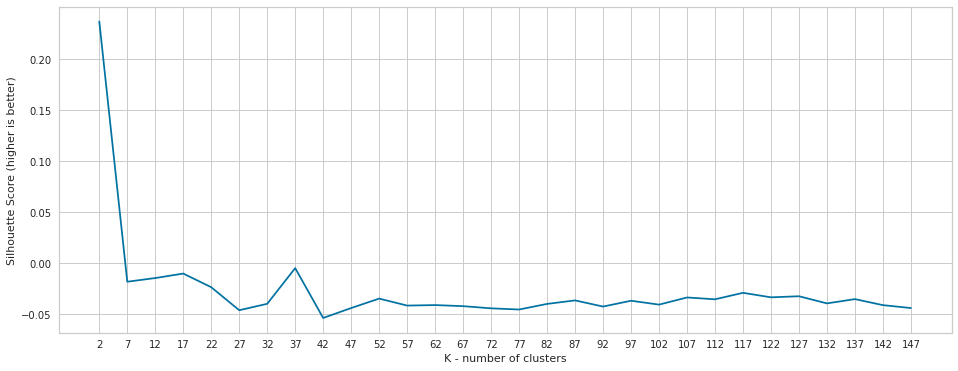

In [ ]:
# Monitor the silouhette score for selection the best "k"

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

## 5 - Final Modelisation
With k-means, we have to specify k, the number of clusters. Let's arbitrarily try k=20 :
We picked k with the elbow method. 
- if the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point.


In [ ]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)
print('Clusters \n',predictions)

Clusters 
 [17  0  3  3  6  1  4  5 15  1 18 18  4 18  8  2  0  7 15 15  0  5  2 18
 18 14 15 18  3 15 15  0  3  3  3 15  5  6  3  3 18 10 10  6  8  3  3 18
  2 15 15  8  8  8 15  6  8  2  4  1  3  2  0 17 18  8  8  0  0  6 15  2
 18  3  8 18 18 15  0 15  8 18 10  8  1  3 17  3  0  7 18 11 15  4 17 18
 18 15 14  3  8  5 15 14  3 18  3  0 11  5  3  3  0 18  2  3  8 18 14  8
  0 18 18 15  6  3 15 10  3 11  0 15  3  3 15  0  8 18  0  3  8 15  3 13
 11  3  3 18  3  0  7 10 15 18  3 15  0  5  8  2 15  8 15  8 15  3 15  8
 15  3  3 15  3 10 15  0  2 13  3 18 14 15 15  7  0  8 18  2  1  8  3  0
  8  1 15 15  5  2  0 11  4 15  8  3  3  3 13 15  0  6 15 15  2  2  6  2
  5 15 15  3  5 11  8 15 15 15  0 15  3  6 15 18 18  1 18 18 18  8  1  3
  3 15 18 10 15  5 15 18  2  2  8  0 18  6 15  5  0  3 15  3  3 10  6  2
  8  0 17 17  4  0 13 18  3  8  6 12  0  3 17 11  3  3 18  3 15 17  8 18
  8  6 11  2  4 14 17  2  2  6  7 15 11  3 12  3  2  0  6  4  3 15 17  1
  1 10 18 18  3 10  3  5 18 18  0 14 18 

To visualize some of these clusters, we'll plot each cluster as a heat map:

cluster # 17
# of users in cluster: 35. # of users in plot: 35


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


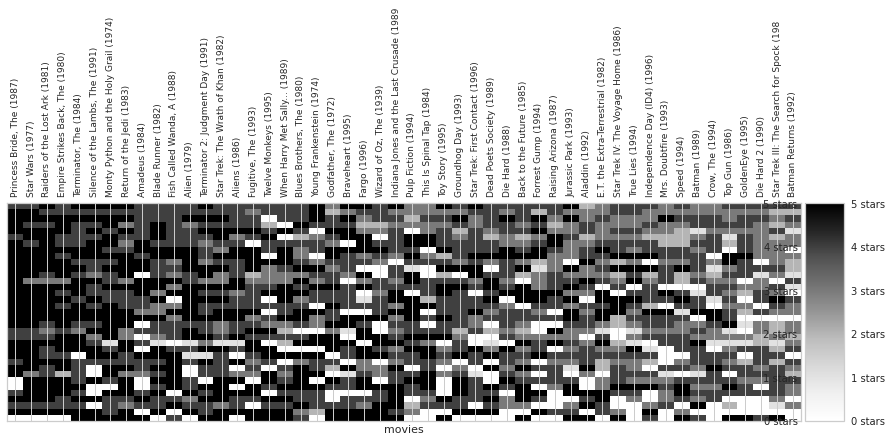

cluster # 0
# of users in cluster: 88. # of users in plot: 70


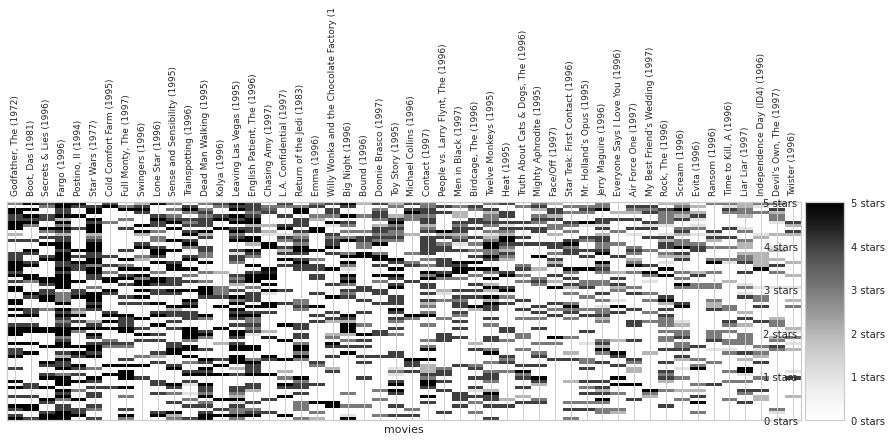

cluster # 3
# of users in cluster: 169. # of users in plot: 70


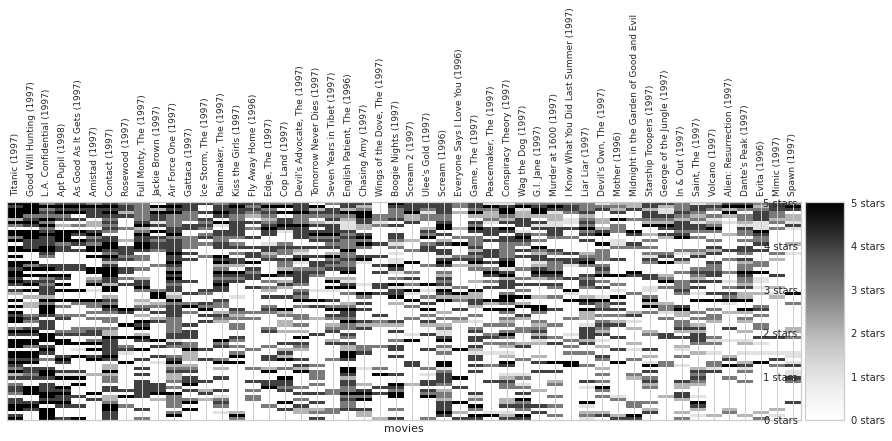

cluster # 6
# of users in cluster: 50. # of users in plot: 50


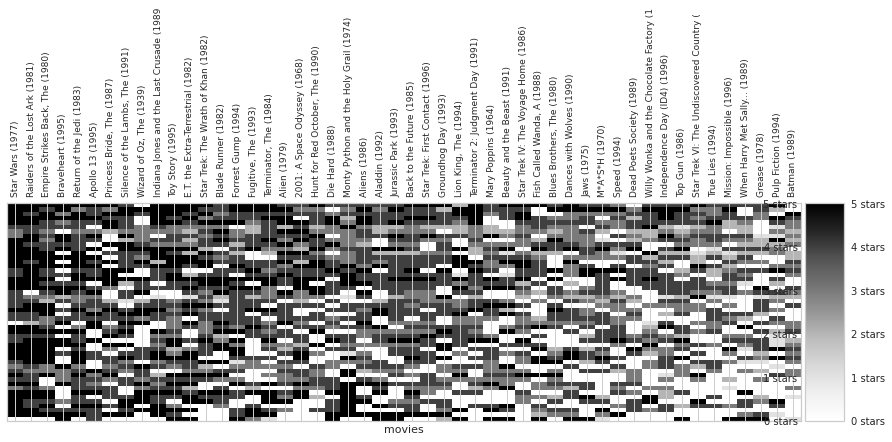

cluster # 1
# of users in cluster: 28. # of users in plot: 28


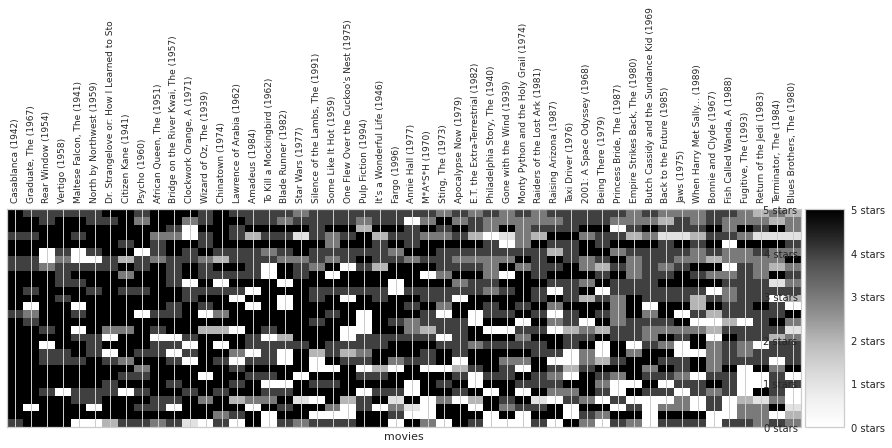

cluster # 4
# of users in cluster: 16. # of users in plot: 16


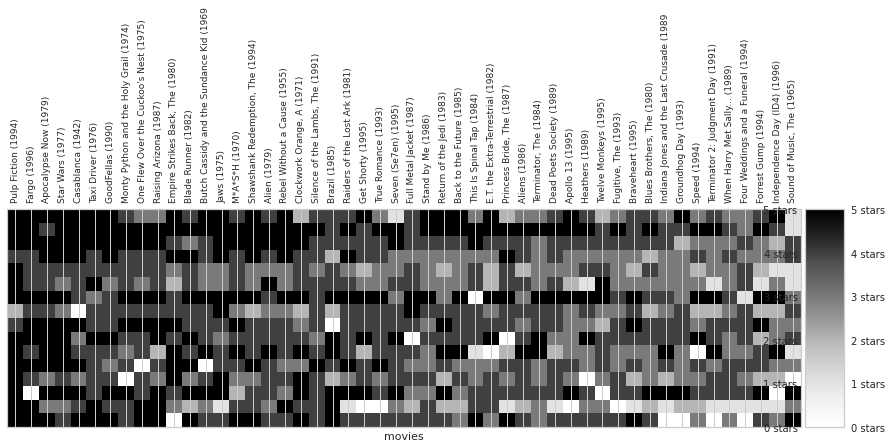

cluster # 5
# of users in cluster: 34. # of users in plot: 34


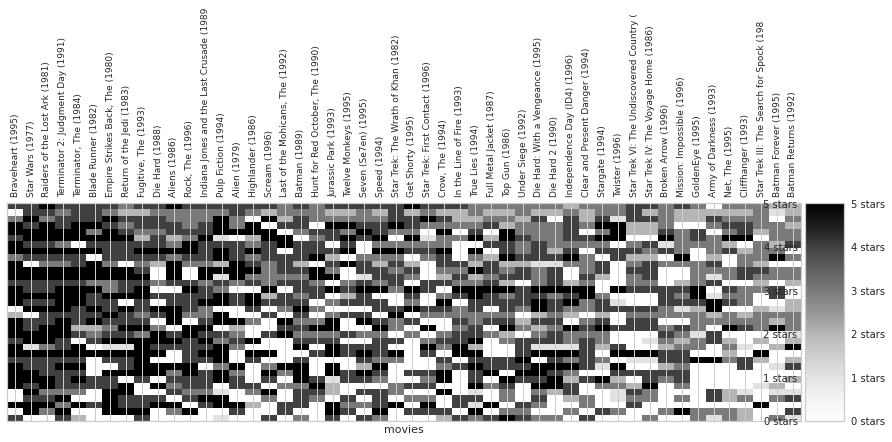

cluster # 15
# of users in cluster: 147. # of users in plot: 70


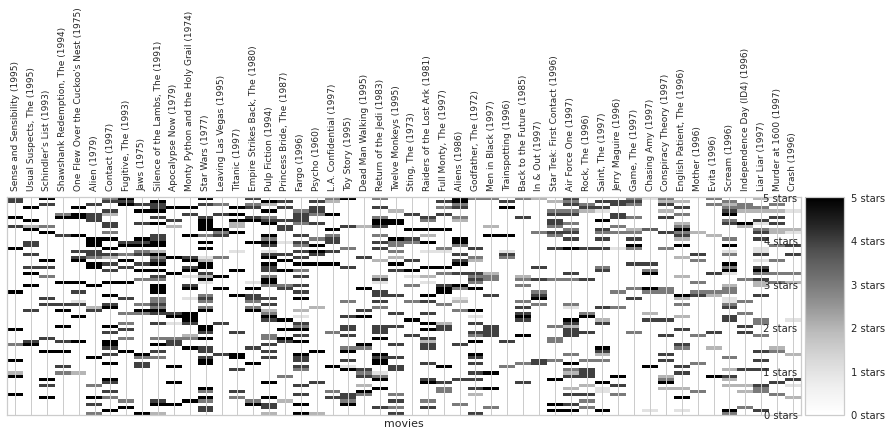

cluster # 18
# of users in cluster: 125. # of users in plot: 70


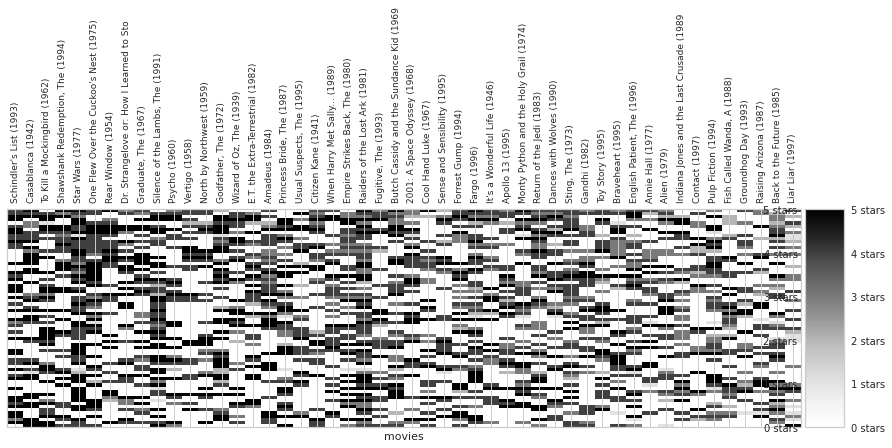

cluster # 8
# of users in cluster: 100. # of users in plot: 70


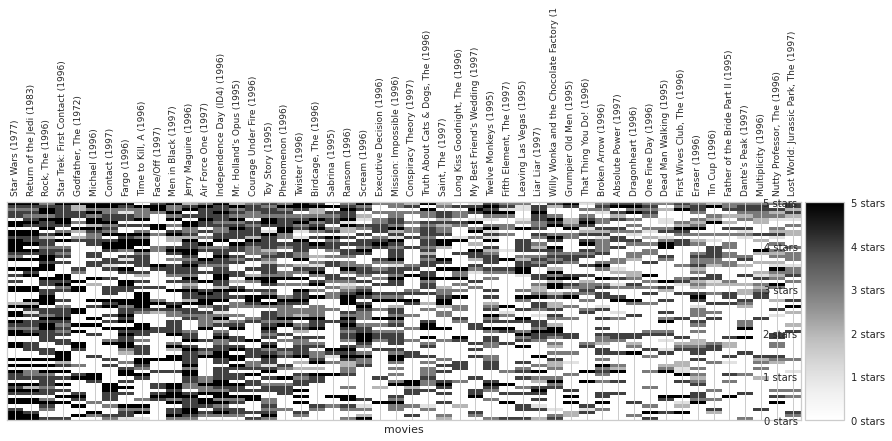

cluster # 2
# of users in cluster: 59. # of users in plot: 59


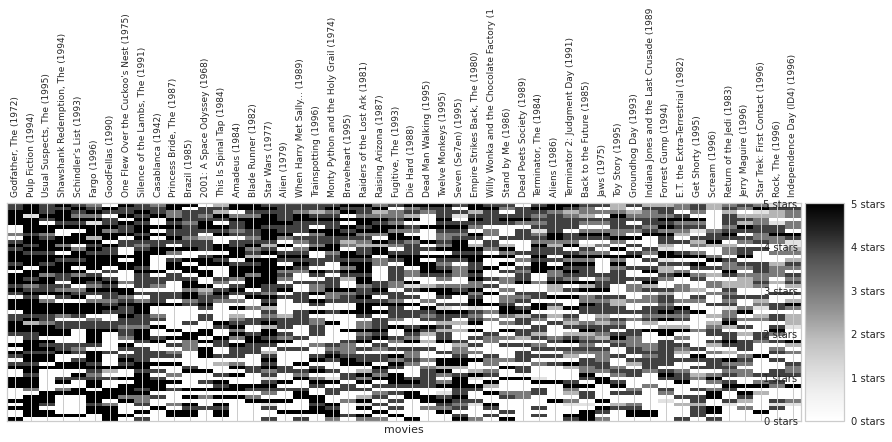

cluster # 14
# of users in cluster: 22. # of users in plot: 22


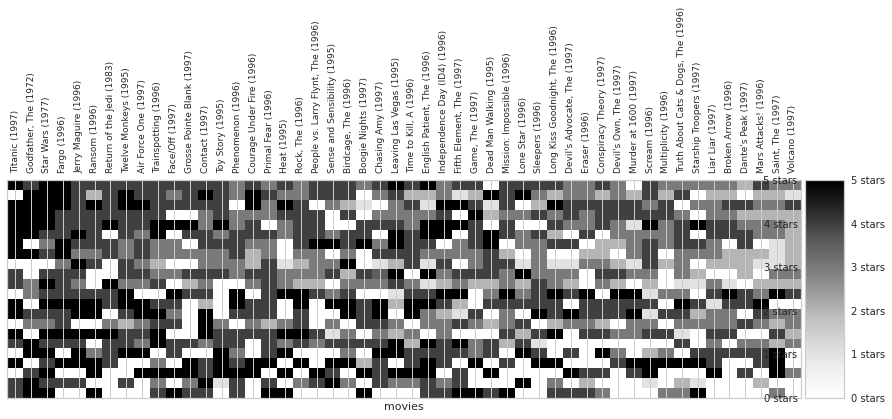

cluster # 10
# of users in cluster: 26. # of users in plot: 26


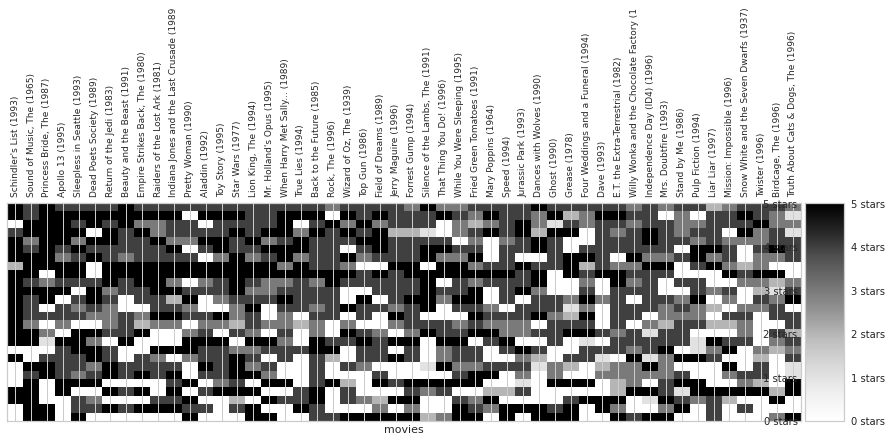

cluster # 11
# of users in cluster: 20. # of users in plot: 20


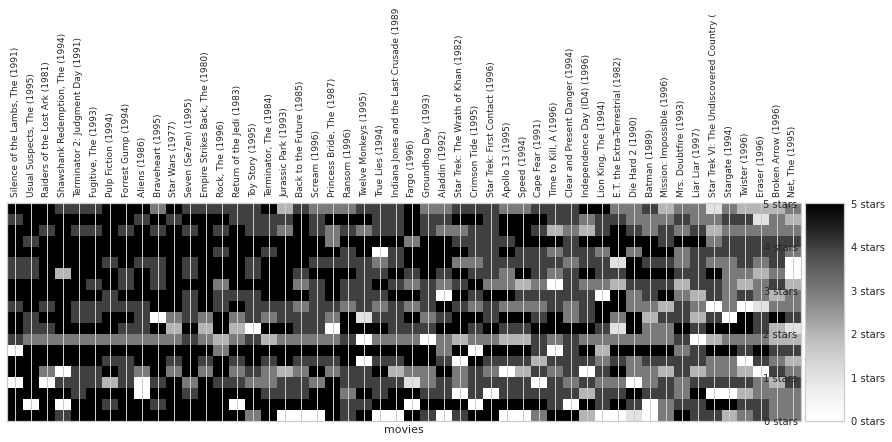

cluster # 13
# of users in cluster: 12. # of users in plot: 12


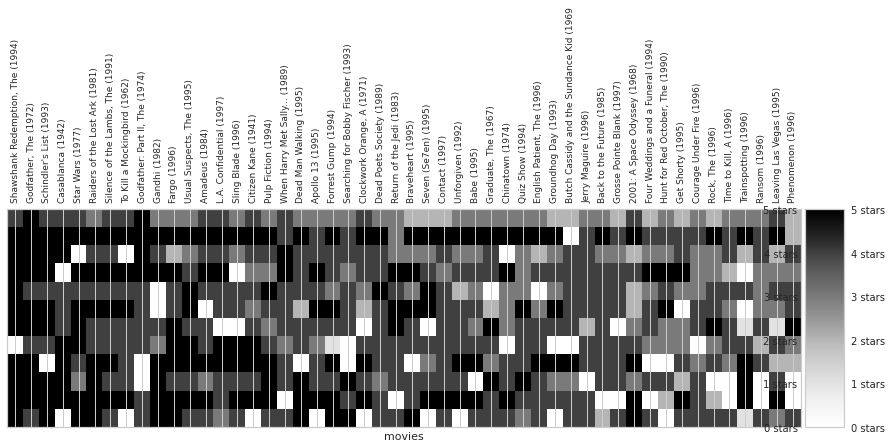

In [ ]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
helper.draw_movie_clusters(clustered, max_users, max_movies)

cluster # 0
# of users in cluster: 88. # of users in plot: 70


'user1_embedding.html'

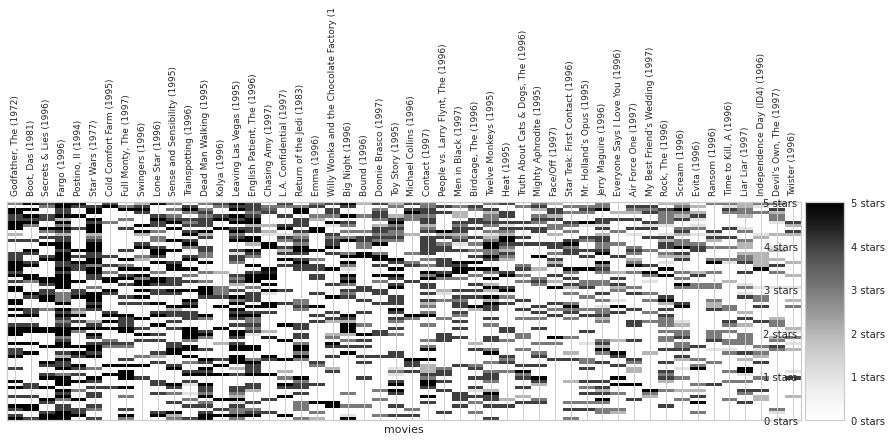

In [ ]:
helper.draw_user_embedding(clustered,
                           user_id=1,
                           max_users=70,
                           max_movies=50)

There are several things to note here:
* The more similar the ratings in a cluster are, the more **vertical** lines in similar colors you'll be able to trace in that cluster. 
* It's super interesting to spot trends in clusters:
 * Some clusters are more sparse than others, containing people who probably watch and rate less movies than in other clusters.
 * Some clusters are mostly yellow and bring together people who really love a certain group of movies. Other clusters are mostly green or navy blue meaning they contain people who agree that a certain set of movies deserves 2-3 stars.
 * Note how the movies change in every cluster. The graph filters the data to only show the most rated movies, and then sorts them by average rating.
 * Can you track where the Lord of the Rings movies appear in each cluster? What about Star Wars movies?
* It's easy to spot **horizontal** lines with similar colors, these are users without a lot of variety in their ratings. A rating of four stars means different things to different people.
* We did a few things to make the clusters visibile (filtering/sorting/slicing). This is because datasets like this are "sparse" and most cells do not have a value (because most people did not watch most movies). 

# 5 - Recommendations
Let's pick a cluster and a specific user and see what useful things this clustering will allow us to do.

Let's first pick a cluster:

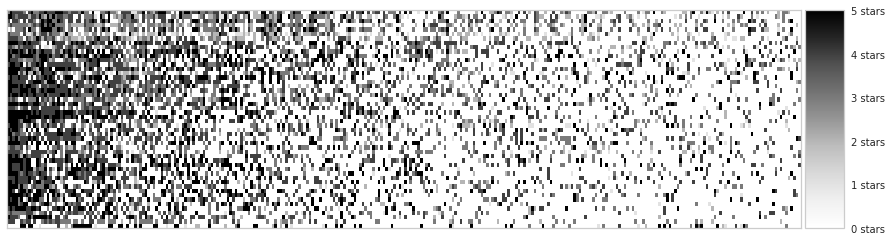

In [ ]:
cluster_number = 6

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = helper.sort_by_rating_density(cluster, n_movies, n_users)
helper.draw_movies_heatmap(cluster, axis_labels=False)

And the actual ratings in the cluster look like this:

In [ ]:
cluster.fillna('').head()

,Star Wars (1977),Raiders of the Lost Ark (1981),Return of the Jedi (1983),"Empire Strikes Back, The (1980)",Back to the Future (1985),Toy Story (1995),Forrest Gump (1994),Indiana Jones and the Last Crusade (1989),E.T. the Extra-Terrestrial (1982),Jurassic Park (1993),...,Swiss Family Robinson (1960),Natural Born Killers (1994),Winnie the Pooh and the Blustery Day (1968),"Net, The (1995)",George of the Jungle (1997),Days of Thunder (1990),"Usual Suspects, The (1995)","Remains of the Day, The (1993)",Face/Off (1997),"Streetcar Named Desire, A (1951)"
42,3.0,5.0,4.0,4.0,4.0,4.0,3.0,,4.0,5.0,...,,2.0,,3.0,3.0,2.0,,,,
26,5.0,5.0,4.0,3.0,4.0,4.0,4.0,4.0,2.0,4.0,...,3.0,2.0,,3.0,,,,,,
16,4.0,,4.0,4.0,3.0,,4.0,,4.0,4.0,...,,,,3.0,,3.0,5.0,,,
39,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,...,,2.0,,,,,,,2.0,
34,,2.0,,3.0,3.0,3.0,4.0,,5.0,3.0,...,,1.0,,3.0,,,5.0,,,


Pick a blank cell from the table. It's blank because that user did not rate that movie. Can we predict whether she would like it or not? Since the user is in a cluster of users that seem to have similar taste, we can take the average of the votes for that movie in this cluster, and that would be a reasonable predicition for much she would enjoy the film.

In [ ]:
# Pick a movie from the table above :
movie_name = "Executive Decision (1996)"

cluster[movie_name].mean()

2.6

And this would be our prediction for how she'd rate the movie.

## Recommendation
Let's reiterate what we did in the previous step. We have used k-means to cluster users according to their ratings. This lead us to clusters of users with similar ratings and thus generally a similar taste in movies. Based on this, when one user did not have a rating for a certain movie  we averaged the ratings of all the other users in the cluster, and that was our guess to how this one user would like the movie.

Using this logic, if we calculate the average score in this cluster for every movie, we'd have an understanding for how this 'taste cluster' feels about each movie in the dataset. 


In [ ]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Star Wars (1977)                             4.541667
Raiders of the Lost Ark (1981)               4.541667
Return of the Jedi (1983)                    4.291667
Empire Strikes Back, The (1980)              4.297872
Back to the Future (1985)                    3.847826
Toy Story (1995)                             4.086957
Forrest Gump (1994)                          3.976744
Indiana Jones and the Last Crusade (1989)    4.093023
E.T. the Extra-Terrestrial (1982)            4.046512
Jurassic Park (1993)                         3.880952
Star Trek: The Wrath of Khan (1982)          4.000000
Monty Python and the Holy Grail (1974)       3.928571
Terminator, The (1984)                       3.951220
Alien (1979)                                 3.951220
Silence of the Lambs, The (1991)             4.121951
Blade Runner (1982)                          4.000000
Aliens (1986)                                3.925000
2001: A Space Odyssey (1968)                 3.950000
Star Trek: First Contact (19

This becomes really useful for us because we can now use it as a recommendation engine that enables our users to discover movies they're likely to enjoy.

When a user logs in to our app, we can now show them recommendations that are appropriate to their taste. The formula for these recommendations is to select the cluster's highest-rated movies that the user did not rate yet.


In [ ]:
# Pick a user ID from the dataset
# Look at the table above outputted by the command "cluster.fillna('').head()" 
# and pick one of the user ids (the first column in the table)
user_id = 5

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Wrong Trousers, The (1993)              4.583333
Close Shave, A (1995)                   4.454545
Titanic (1997)                          4.450000
Usual Suspects, The (1995)              4.444444
12 Angry Men (1957)                     4.250000
Hamlet (1996)                           4.222222
Killing Fields, The (1984)              4.200000
Good Will Hunting (1997)                4.200000
Man Who Would Be King, The (1975)       4.181818
Glory (1989)                            4.157895
North by Northwest (1959)               4.150000
Bridge on the River Kwai, The (1957)    4.137931
Wizard of Oz, The (1939)                4.114286
E.T. the Extra-Terrestrial (1982)       4.046512
Blade Runner (1982)                     4.000000
In the Name of the Father (1993)        4.000000
Birds, The (1963)                       4.000000
Star Trek: The Wrath of Khan (1982)     4.000000
Rear Window (1954)                      4.000000
Boot, Das (1981)                        4.000000
Name: 0, dtype: floa

Top 20 recommendations to the user!

### Possible issues / Remarks
-  If the cluster had a movie with only one rating. And that rating was 5 stars the average rating of the cluster for that movie is 5. It can affect our simple recommendation engine. 

- We could weight the features based on number of rating to address this issue.

- If we want to dig deeper in movie rating exploration, we you can look at the [Full dataset](https://grouplens.org/datasets/movielens/) containing 24 million ratings.



# Metrics

In [ ]:
import plotly.express as px

mean_ratings = helper.sort_by_rating_density(user_movie_ratings, 1000, 943).mean()
most_viewed_movies = helper.sort_by_rating_density(user_movie_ratings, 1000, 943).count()
movies_distrib = pd.concat([most_viewed_movies,mean_ratings], axis=1)
movies_distrib = movies_distrib.reset_index()
movies_distrib.columns = ['title','N_ratings','mean_ratings']
movies_distrib = movies_distrib.sort_values(["mean_ratings", "N_ratings"], ascending = (False, False))

fig = px.histogram(movies_distrib, x="mean_ratings", y="N_ratings", nbins=1000, marginal="rug", hover_data=movies_distrib.columns)
fig.show()